In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
import os
from dotenv import load_dotenv
load_dotenv()
from langgraph.prebuilt import ToolNode,tools_condition



In [ ]:
class State(TypedDict):

    """
    Attributes:
        messages (list): List of messages in the conversation.
        Annotated[..] : Tells LangGraph: “Use this merge logic when updating this list field”
        add_messages : A helper that defines how to combine messages over time in LangGraph

    info:
        The typedDict tells the State class it expects a dictionary with the a key called meassages
    """

    messages:Annotated[list,add_messages]


In [6]:
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021184A01790>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021184B3B410>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
graph_builder=StateGraph(State)
graph_builder.add_node("llm_chatbot",chatbot)
graph_builder.add_edge(START,"llm_chatbot")
graph_builder.add_edge("llm_chatbot",END)
graph=graph_builder.compile()

In [10]:
response=graph.invoke({"messages":"hi"})
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

# LLM with tools

In [20]:
from langchain_tavily import TavilySearch

tavily_srch=TavilySearch(max_results=2)
#tool.invoke("what is the qatar news What is 5 by 2")

In [8]:
def multiply(a:int,b:int)->int:

    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    
    return a*b
    

In [21]:
tools=[tavily_srch,multiply]

In [22]:
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021184A01790>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021184B3B410>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

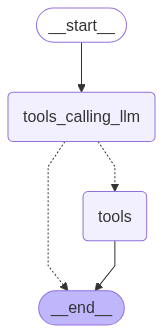

In [66]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]+state["messages"] }

graph_builder=StateGraph(State)
graph_builder.add_node("tools_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools))

# Add Edges
graph_builder.add_edge(START,"tools_calling_llm")
graph_builder.add_conditional_edges(
    "tools_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition)
graph_builder.add_edge("tools",END)

graph=graph_builder.compile()
graph

In [69]:
response = graph.invoke({
    "messages": ["What is the weather today and what is 5 multiplied by 3 and divided by 10 "]
})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the weather today and what is 5 multiplied by 3 and divided by 10 
================================== Ai Message ==================================
Tool Calls:
  tavily_search (rj619mpdg)
 Call ID: rj619mpdg
  Args:
    query: What is the weather today?
  multiply (bcc3na0f4)
 Call ID: bcc3na0f4
  Args:
    a: 5
    b: 3
  multiply (ddqerhegv)
 Call ID: ddqerhegv
  Args:
    a: 15
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "What is the weather today?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in current location", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Current', 'region': 'Harbour Island', 'country': 'Bahamas', 'lat': 25.4333, 'lon': -76.7833, 'tz_id': 'America/Nassau', 'localtime_epoch': 1751404348, 'localtime': '2025-07-01 17:12'}, 'cur

# React Agent

In [71]:
from langchain_tavily import TavilySearch
tavily_srch=TavilySearch(max_results=2)

In [72]:
def multiply(x: int, y: int) -> int:
    """Multiply x and y

    Args:
        x (int): first int
        y (int): second int

    Returns:
        int: output int
    """
    return x * y

In [74]:
llm_tools_list = [tavily_srch, multiply]

llm_with_tools = llm.bind_tools(llm_tools_list)

In [82]:
def calling_llm(state:State):
    response=llm_with_tools.invoke(state["messages"])
    return {"messages":[response]+state["messages"]}


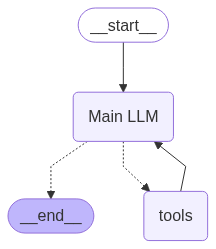

In [83]:
react_agent=StateGraph(State)

react_agent.add_node("Main LLM",calling_llm)
react_agent.add_node("tools",ToolNode(llm_tools_list))

react_agent.add_edge(START,"Main LLM")
react_agent.add_conditional_edges(
    "Main LLM",
    tools_condition)
react_agent.add_edge("tools","Main LLM")


react_agent_graph=react_agent.compile()
react_agent_graph

In [85]:
response=react_agent_graph.invoke({"messages":"what is the qatar news AND THEN What is 5 by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the qatar news AND THEN What is 5 by 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (x6n36g3ex)
 Call ID: x6n36g3ex
  Args:
    query: qatar news
  multiply (52bd9ab6g)
 Call ID: 52bd9ab6g
  Args:
    x: 5
    y: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "qatar news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Qatar Tribune - LATEST NEWS", "url": "https://www.qatar-tribune.com/latest-news", "content": "DOHA: His Highness the Amir of the State of Qatar Sheikh Tamim bin Hamad Al Thani has received a written message from President of the Islamic Republic of Iran HE Dr Masoud Pezeshkian pertaining to bilateral ties and the means to enhance them.The message was received by Minister of State for Foreign Affairs HE Sultan bin Saad A

In [20]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class AgentState(TypedDict):
    messages: List[dict]

def tool_calling_llm(state: AgentState) -> AgentState:
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}

graph_builder = StateGraph(AgentState)
graph_builder.add_node("tools_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "tools_calling_llm")
graph_builder.add_conditional_edges("tools_calling_llm", tools_condition)
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()


In [22]:
response = graph.invoke({
    "messages": [{"role": "user", "content": "what is july 4th ? "}]
})

# Print each message
for m in response["messages"]:
    m.pretty_print()


================================= Tool Message =================================
Name: tavily_search

{"query": "what is july 4th", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What Is the 4th of July?| 4th of July Meaning, History and Celebrations ...", "url": "https://www.rd.com/article/4th-of-july-history/", "content": "July 4th (also known as Independence Day) is an annual American holiday that falls on, you guessed it, the 4th of July.", "score": 0.87706697, "raw_content": null}, {"title": "Independence Day (United States) - Wikipedia", "url": "https://en.wikipedia.org/wiki/Independence_Day_(United_States)", "content": "**Independence Day**, known colloquially as the **Fourth of July**, is a federal holiday in the United States which commemorates the ratification of the Declaration of Independence by the Second Continental Congress on July 4, 1776, establishing the United States of America. | Fireworks displays, such as these over the Washingto

In [24]:

from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, List

# LLM
llm=init_chat_model("groq:llama3-8b-8192")

# Tools
@tool
def multiply(a: int, b: int) -> int:
    """muitlupg a and b """
    return a * b

tools = [multiply]

# Bind tools
llm_with_tools = llm.bind_tools(tools)

# State definition
class AgentState(TypedDict):
    messages: List[dict]

# Node: run LLM with tools
def tool_calling_llm(state: AgentState) -> AgentState:
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}  # ✅ APPEND!

# Build graph
graph_builder = StateGraph(AgentState)
graph_builder.add_node("tools_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "tools_calling_llm")
graph_builder.add_conditional_edges("tools_calling_llm", tools_condition)
graph_builder.add_edge("tools", "tools_calling_llm")  # ✅ loop back
graph_builder.add_edge("tools_calling_llm", END)  # fallback

graph = graph_builder.compile()


In [25]:
response = graph.invoke({
    "messages": [{"role": "user", "content": "What is 5 multiplied by 3?"}]
})
response

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n  "tool_calls": [\n    {\n      "id": "pending",\n      "type": "function",\n      "function": {\n        "name": "multiply",\n        "parameters": {\n          "a": 12000,\n          "b": 2\n        }\n      }\n    }\n  ]\n}\n</tool-use>'}}

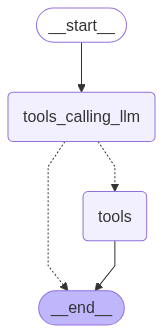

In [65]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.utils.function_calling import convert_to_openai_tool

# Define State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
tool = TavilySearch(max_results=2)


def multiply(a, b):
    """Multiply a and b"""
    return a * b

tools = [tool, multiply]

# LLM
llm_with_tools = llm.bind_tools(tools)

# Tool-calling node
def tool_calling_llm(state: State) -> State:
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}

# Build Graph
graph_builder = StateGraph(State)
graph_builder.add_node("tools_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "tools_calling_llm")
graph_builder.add_conditional_edges("tools_calling_llm", tools_condition)
graph_builder.add_edge("tools", END)

graph_builder.compile()


In [4]:
response = graph.invoke({
    "messages": [{"role": "user", "content": "What is 5 multiplied by 3 tell me where are the firework for july 4th?"}]
})
response

NameError: name 'graph' is not defined